In [38]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
CLASS_COUNT = 4  # 0, 1, 2, 3 (we convert 4 to 3 later)



In [39]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.samples = []
        self.transform = transform

        for s in sorted(os.listdir(root_dir)):
            try:
                num = int(s.split("_")[-1])  # مثل BraTS20_Training_001
                if num > 354:
                    continue  # فقط تا 354 رو می‌خوایم
            except:
                continue  # اگر پوشه فرمت عجیبی داشت

            base_path = os.path.join(root_dir, s)
            required = [f"{s}_flair.nii", f"{s}_t1.nii", f"{s}_t1ce.nii", f"{s}_t2.nii", f"{s}_seg.nii"]
            if all(os.path.exists(os.path.join(base_path, f)) for f in required):
                self.samples.append(s)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        sample_path = os.path.join(self.root_dir, sample_id)

        flair = nib.load(os.path.join(sample_path, sample_id + "_flair.nii")).get_fdata()
        t1 = nib.load(os.path.join(sample_path, sample_id + "_t1.nii")).get_fdata()
        t1ce = nib.load(os.path.join(sample_path, sample_id + "_t1ce.nii")).get_fdata()
        t2 = nib.load(os.path.join(sample_path, sample_id + "_t2.nii")).get_fdata()
        seg = nib.load(os.path.join(sample_path, sample_id + "_seg.nii")).get_fdata()

        # فقط یک برش وسطی (slice 80)
        slice_idx = 80
        image = np.stack([flair[:, :, slice_idx], t1[:, :, slice_idx],
                          t1ce[:, :, slice_idx], t2[:, :, slice_idx]], axis=0)
        mask = seg[:, :, slice_idx].astype(np.int64)
        mask[mask == 4] = 3  # تبدیل کلاس 4 به 3

        image = (image - image.mean()) / image.std()
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [40]:
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=4,                  
    classes=CLASS_COUNT,            
).to(DEVICE)


In [41]:
def train(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


In [43]:
def visualize(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(DEVICE))
        pred = torch.argmax(pred.squeeze(), dim=0).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0], cmap='gray')
    axs[0].set_title('FLAIR')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Prediction')
    plt.tight_layout()
    plt.show()


Epoch 1/3, Loss: 124.5339
Epoch 2/3, Loss: 95.1094
Epoch 3/3, Loss: 78.8062


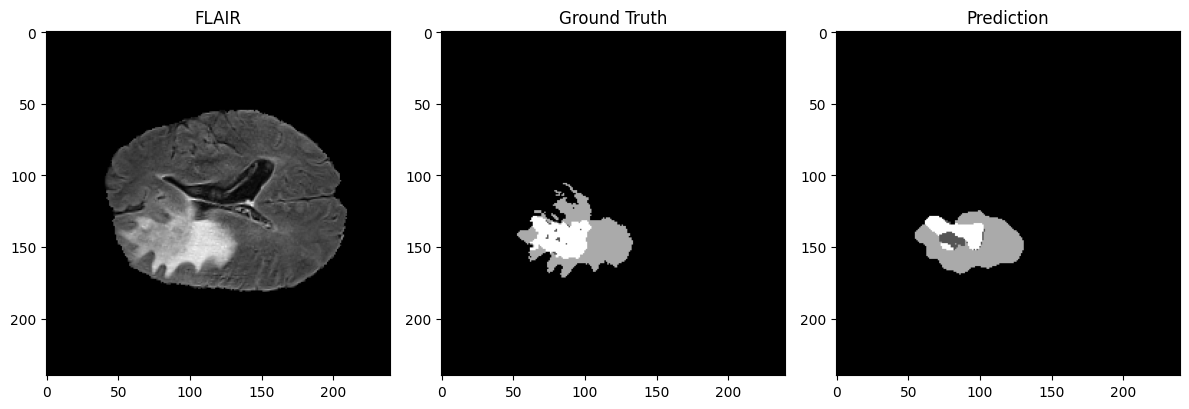

In [44]:
if __name__ == "__main__":
    dataset = BraTSDataset(DATA_DIR)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)

    criterion = smp.losses.DiceLoss(mode='multiclass')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train(model, loader, optimizer, criterion, epochs=3)
    visualize(model, dataset, idx=5)